In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

%matplotlib widget
from tqdm import trange

import physicsConsts as c
from simulation_functions import get_AM3, blastwave, powerlaw_array
from plotting_functions import plot_spectrum, plot_coolingtimes
import setFigureConfig as sfc

from colorschemes import get_comp_cols
compcols = get_comp_cols()


# set up AM3

In [2]:
am3 = get_AM3(exp=1, hadronic=0, qsyn=0) # expansion needed for time dependent method
am3.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 1
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 0
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [3]:
# short cuts for energy grids
Ee_eV = am3.get_egrid_lep()
Ee_erg = Ee_eV * c.eV2erg
Eg_eV = am3.get_egrid_photons()
Eg_erg = Eg_eV * c.eV2erg
Ep_eV = am3.get_egrid_had()
Ep_erg = Ep_eV * c.eV2erg
En_eV = am3.get_egrid_neutrinos()
En_erg = En_eV * c.eV2erg

## set parameters

In [4]:
Gamma = 10**1.7
n = 1 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-4
epsilon_e = 10**-1.5
epsilon_p = 0
p = 2.3
Emin = 10**9 # eV
eta = 1
Ntdyn = 5
fdt = 5e-2 # time step as a fraction of dynamical time
z = 0.1

## run simulation

In [5]:
am3.clear_particle_densities()
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # log time steps
    t_obs_evo = (1-fdt)**(N_evo-i -1) * t_obs
    t_dyn, n_target, p_ram_eval, B = blastwave(
        t_obs_evo, Gamma, n, t_obs, epsilon_B)

    # update parameters
    am3.set_escape_timescale(t_dyn)
    am3.set_expansion_timescale(t_dyn)
    am3.set_solver_time_step(fdt * t_dyn)
    am3.set_pp_target_proton_density(n_target)
    am3.set_mag_field(B)

    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()


100%|██████████| 100/100 [00:01<00:00, 56.63it/s]


# plots

## photon spectra

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/2363990850.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


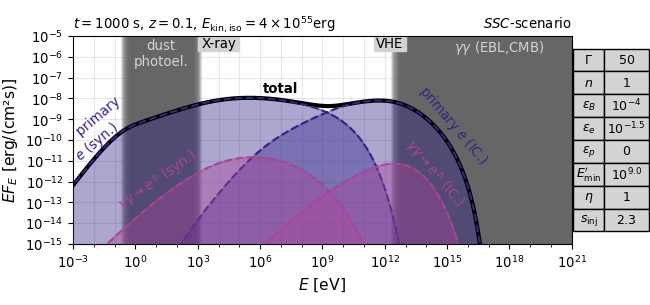

In [6]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*am3.get_photons(), 
    E2dN_dE_tot_nu=En_erg*am3.get_neutrinos(),
    components=[
        [Eg_erg*am3.get_photons_injected_electrons_syn(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_annihilation_pairs_syn(), compcols["pair"], True, 1, "--", None, 1.5],
        [Eg_erg*am3.get_photons_annihilation_pairs_compton(), compcols["pair"], True, 1, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], xlim=[1e-3, 1e21], cgrey="#666666", col_tot=compcols["total"], col_nu=compcols["nu"]
)

ax.text(2e-2, 4e-10, "   primary\n " r"$e$" + " (syn.)       ", color=compcols["in"], va="center", ha="center", zorder=100, rotation=40)
ax.text(2e15, 5e-10, r"primary $e$ (IC.)", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ (IC.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ (syn.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)
# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3)
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
table_data = [
    [r"$\Gamma$",r"$n$",r"$\varepsilon_B$",r"$\varepsilon_e$", r"$\varepsilon_p$", r"$E_\mathrm{min}'$",r"$\eta$", r"$s_\mathrm{inj}$"],
    [int(Gamma), int(n)] + 
    [r"$10^{%g}$"% np.log10(x) for x in [epsilon_B, epsilon_e]]+ [epsilon_p] +
    [r"$10^{%.1f}$"% np.log10(x) for x in [Emin]] + [int(eta), p]
]


ax.set_title(ax.get_title(loc="left")+ r", $E_\mathrm{kin,iso}=4\times 10^{55} \mathrm{erg}$", loc="left")

# Create a table
table = Table(axtbl, loc='center right')

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        tablecol = "lightgrey"
        table.add_cell(
            j, i, width=0.65 +i*0.3, height=0.11, text=cell, loc='center', 
            facecolor=tablecol)

axtbl.axis("off")
# Adjust the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(9)

# Add the table to the subplot
axtbl.add_table(table)


plt.subplots_adjust(left=0.06, right=1, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-photons", dpi=500)

### build up

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/1276784865.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


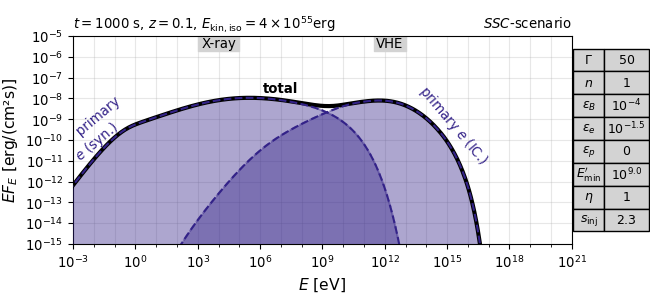

In [7]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*am3.get_photons(), 
    E2dN_dE_tot_nu=En_erg*am3.get_neutrinos(),
    components=[
        [Eg_erg*am3.get_photons_injected_electrons_syn(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), compcols["in"], True, 0, "--", None, 1.5],
        # [Eg_erg*am3.get_photons_annihilation_pairs_syn(), compcols["pair"], True, 1, "--", None, 1.5],
        # [Eg_erg*am3.get_photons_annihilation_pairs_compton(), compcols["pair"], True, 1, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], xlim=[1e-3, 1e21], cgrey="None", col_tot=compcols["total"], col_nu=compcols["nu"], labels_grey=["",""]
)

ax.text(2e-2, 4e-10, "   primary\n " r"$e$" + " (syn.)       ", color=compcols["in"], va="center", ha="center", zorder=100, rotation=40)
ax.text(2e15, 5e-10, r"primary $e$ (IC.)", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ (IC.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ (syn.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)
# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3)
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
table_data = [
    [r"$\Gamma$",r"$n$",r"$\varepsilon_B$",r"$\varepsilon_e$", r"$\varepsilon_p$", r"$E_\mathrm{min}'$",r"$\eta$", r"$s_\mathrm{inj}$"],
    [int(Gamma), int(n)] + 
    [r"$10^{%g}$"% np.log10(x) for x in [epsilon_B, epsilon_e]]+ [epsilon_p] +
    [r"$10^{%.1f}$"% np.log10(x) for x in [Emin]] + [int(eta), p]
]


ax.set_title(ax.get_title(loc="left")+ r", $E_\mathrm{kin,iso}=4\times 10^{55} \mathrm{erg}$", loc="left")

# Create a table
table = Table(axtbl, loc='center right')

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        tablecol = "lightgrey"
        table.add_cell(
            j, i, width=0.65 +i*0.3, height=0.11, text=cell, loc='center', 
            facecolor=tablecol)

axtbl.axis("off")
# Adjust the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(9)

# Add the table to the subplot
axtbl.add_table(table)


plt.subplots_adjust(left=0.06, right=1, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-photons_1", dpi=500)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/1986658374.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


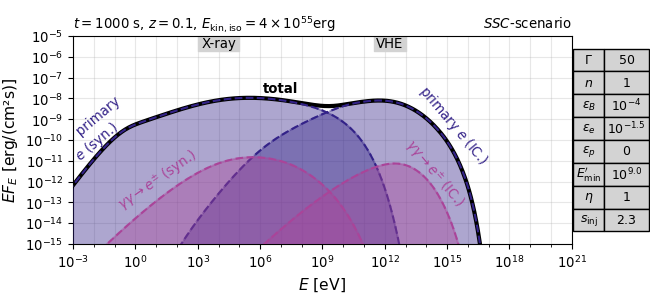

In [8]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*am3.get_photons(), 
    E2dN_dE_tot_nu=En_erg*am3.get_neutrinos(),
    components=[
        [Eg_erg*am3.get_photons_injected_electrons_syn(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_annihilation_pairs_syn(), compcols["pair"], True, 1, "--", None, 1.5],
        [Eg_erg*am3.get_photons_annihilation_pairs_compton(), compcols["pair"], True, 1, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], xlim=[1e-3, 1e21], cgrey="None", col_tot=compcols["total"], col_nu=compcols["nu"], labels_grey=["",""]
)

ax.text(2e-2, 4e-10, "   primary\n " r"$e$" + " (syn.)       ", color=compcols["in"], va="center", ha="center", zorder=100, rotation=40)
ax.text(2e15, 5e-10, r"primary $e$ (IC.)", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ (IC.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ (syn.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)
# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3)
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
table_data = [
    [r"$\Gamma$",r"$n$",r"$\varepsilon_B$",r"$\varepsilon_e$", r"$\varepsilon_p$", r"$E_\mathrm{min}'$",r"$\eta$", r"$s_\mathrm{inj}$"],
    [int(Gamma), int(n)] + 
    [r"$10^{%g}$"% np.log10(x) for x in [epsilon_B, epsilon_e]]+ [epsilon_p] +
    [r"$10^{%.1f}$"% np.log10(x) for x in [Emin]] + [int(eta), p]
]


ax.set_title(ax.get_title(loc="left")+ r", $E_\mathrm{kin,iso}=4\times 10^{55} \mathrm{erg}$", loc="left")

# Create a table
table = Table(axtbl, loc='center right')

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        tablecol = "lightgrey"
        table.add_cell(
            j, i, width=0.65 +i*0.3, height=0.11, text=cell, loc='center', 
            facecolor=tablecol)

axtbl.axis("off")
# Adjust the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(9)

# Add the table to the subplot
axtbl.add_table(table)


plt.subplots_adjust(left=0.06, right=1, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-photons_2", dpi=500)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/3740103887.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


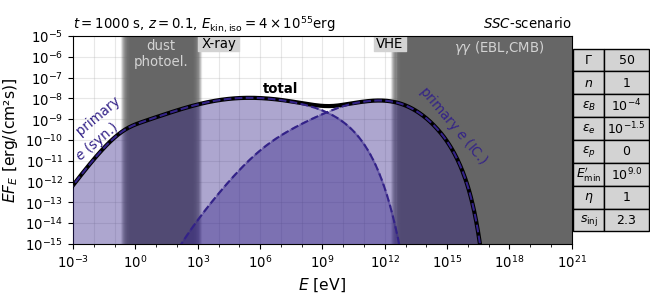

In [9]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*am3.get_photons(), 
    E2dN_dE_tot_nu=En_erg*am3.get_neutrinos(),
    components=[
        [Eg_erg*am3.get_photons_injected_electrons_syn(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), compcols["in"], True, 0, "--", None, 1.5],
        # [Eg_erg*am3.get_photons_annihilation_pairs_syn(), compcols["pair"], True, 1, "--", None, 1.5],
        # [Eg_erg*am3.get_photons_annihilation_pairs_compton(), compcols["pair"], True, 1, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], xlim=[1e-3, 1e21], cgrey="#666666", col_tot=compcols["total"], col_nu=compcols["nu"]
)

ax.text(2e-2, 4e-10, "   primary\n " r"$e$" + " (syn.)       ", color=compcols["in"], va="center", ha="center", zorder=100, rotation=40)
ax.text(2e15, 5e-10, r"primary $e$ (IC.)", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ (IC.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ (syn.)", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)
# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3)
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
table_data = [
    [r"$\Gamma$",r"$n$",r"$\varepsilon_B$",r"$\varepsilon_e$", r"$\varepsilon_p$", r"$E_\mathrm{min}'$",r"$\eta$", r"$s_\mathrm{inj}$"],
    [int(Gamma), int(n)] + 
    [r"$10^{%g}$"% np.log10(x) for x in [epsilon_B, epsilon_e]]+ [epsilon_p] +
    [r"$10^{%.1f}$"% np.log10(x) for x in [Emin]] + [int(eta), p]
]


ax.set_title(ax.get_title(loc="left")+ r", $E_\mathrm{kin,iso}=4\times 10^{55} \mathrm{erg}$", loc="left")

# Create a table
table = Table(axtbl, loc='center right')

# Add cells to the table
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        tablecol = "lightgrey"
        table.add_cell(
            j, i, width=0.65 +i*0.3, height=0.11, text=cell, loc='center', 
            facecolor=tablecol)

axtbl.axis("off")
# Adjust the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(9)

# Add the table to the subplot
axtbl.add_table(table)


plt.subplots_adjust(left=0.06, right=1, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-photons_3", dpi=500)

## timescales

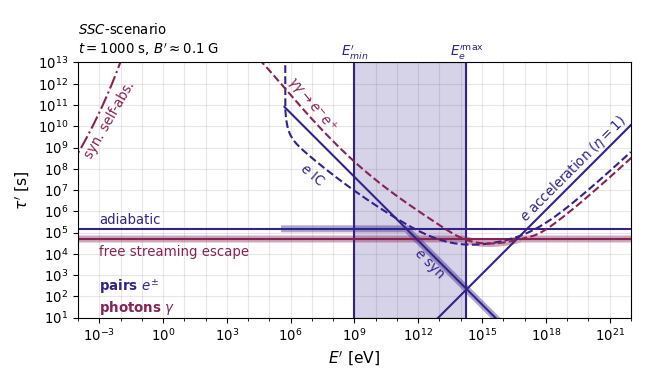

In [10]:
%matplotlib widget
sfc.fullWidth(aspectRatio=0.6, alpha=0.8)
fig, ax = plt.subplots() #figsize=(6,3))
cgamma = compcols["pp"]

inds_e = (Ee_eV<1e100)# am3.get_estimated_electron_emax())
tdom_e = np.minimum(am3.get_t_pair_adiabatic(), am3.get_t_pair_syn())
ax.loglog(Ee_eV[inds_e], tdom_e[inds_e], alpha=0.4, color=compcols["in"], lw=5)

tdom_g = np.minimum(am3.get_t_photon_escape(), am3.get_t_photon_annihilation())
ax.loglog(Eg_eV, tdom_g, alpha=0.4, color=cgamma, lw=5)

ax = plot_coolingtimes(
    ax, Ep_eV, Ee_eV, Eg_eV, 0, Emin, Emin,
    [am3.get_t_proton_syn()], [am3.get_t_proton_adiabatic()],
    [am3.get_t_proton_acceleration()], [am3.get_t_proton_compton()],
    [am3.get_t_proton_bethe_heitler()], [am3.get_t_proton_photopion()],
    [am3.get_t_proton_proton_proton()], [am3.get_t_pair_syn()],
    [am3.get_t_pair_compton()], [am3.get_t_pair_acceleration()],
    [am3.get_t_photon_escape()], [am3.get_t_photon_annihilation()],
    [am3.get_t_photon_ssa()], 
    am3.get_t_pion_decay(), am3.get_t_muon_decay(), leptonic=True,
    ylim=[1e1, 1e13], xlim=[1e-4, 1e22], cel=compcols["in"], cproton=compcols["p"],
    cpion=compcols["pi"], cmuon=compcols["mu"], cgamma=cgamma
)

ax.text(3e-3, 2e10, r"syn. self-abs.", color=cgamma, va="center", ha="center", zorder=100, rotation=60)
ax.text(1e7, 1e11, r"$\gamma\gamma \to e^{-}e^{+}$", color=cgamma, va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e-3, 1.2e4, r"free streaming escape", color=cgamma, va="center", ha="left", zorder=100, rotation=0)
ax.text(1e-3, 4e5, r"adiabatic", color=compcols["in"], va="center", ha="left", zorder=100, rotation=0)

ax.text(1e7, 5e7, r"$e$ IC", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-40)
ax.text(3e12, 3e3, r"$e$ syn", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-45)
ax.text(1e9, 3e13, r"$E_{min}'$", color=compcols["in"], va="center", ha="center", zorder=100, rotation=0)
ax.text(2e14, 3e13, r"$E_e^{\prime\mathrm{max}}$", color=compcols["in"], va="center", ha="center", zorder=100, rotation=0)


ax.text(2e19, 1e8, r"$e$ acceleration ($\eta=1$)", color=compcols["in"], va="center", ha="center", zorder=100, rotation=45)

ax.text(1e-3, 3e2, r"pairs $e^{\pm}$", color=compcols["in"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e1, r"photons $\gamma$", color=cgamma, va="center", ha="left", zorder=100, rotation=0, weight="bold")
title_string = r"$SSC$-scenario" + "\n"
title_string += r"$t=" + f"{1000}"
title_string += r"$ s"
if B is not None:
    title_string += r", $B'\approx %.1f \; \mathrm{G}$" %(B)
# title_string += r", $\eta = %g $" %(eta)
# title_string += "$"
ax.set_title(title_string, loc="left")
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-timescales", dpi=500)

# Steaty State result

In [6]:
am3_ss = get_AM3(exp=0, hadronic=0, qsyn=0) # expansion needed for time dependent method
am3_ss.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 0
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:0
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 0
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [7]:
am3_ss.clear_particle_densities()
# update parameters
am3_ss.set_electron_accel_factor(eta)
am3_ss.set_proton_accel_factor(eta)
am3_ss.set_escape_fraction_charged_particles(0)
am3_ss.set_escape_fraction_neutral_particles(1)
t_dyn, n_target, p_ram_eval, B = blastwave(t_obs, Gamma, n, t_obs, epsilon_B)
am3_ss.set_escape_timescale(t_dyn)
am3_ss.set_expansion_timescale(t_dyn)
am3_ss.set_solver_time_step(fdt * t_dyn)
am3_ss.set_pp_target_proton_density(n_target)
am3_ss.set_mag_field(B)

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # estimate max. energy
    if i>0:
        am3_ss.estimate_max_electron_energy()
        Eemax = am3_ss.get_estimated_electron_emax()
        am3_ss.estimate_max_proton_energy()
        Epmax = am3_ss.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3_ss.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    
    am3_ss.evolve_step()

100%|██████████| 100/100 [00:01<00:00, 68.20it/s]


/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_91962/3736178401.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


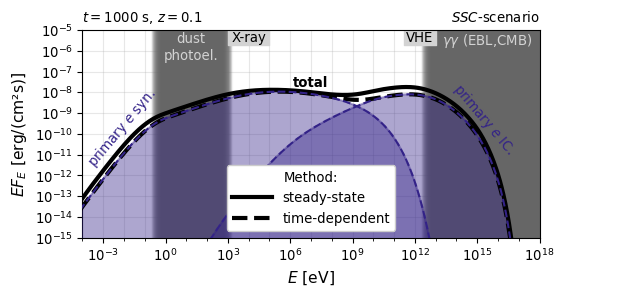

In [9]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", "steady-state", 3],
        [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_syn(), compcols["in"], True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), compcols["in"], True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], cgrey="#666666", Emaxs_grey=[3e2, 1e18]
)

ax.text(8e-3, 2e-10, r"primary $e$ syn.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=50)
ax.text(2e15, 5e-10, r"primary $e$ IC.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-methods")
fig

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_91962/3804960358.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


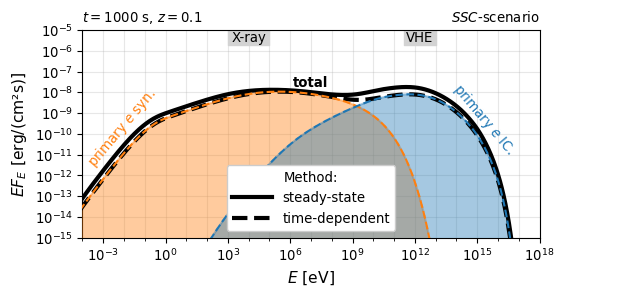

In [13]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", "steady-state", 3],
        [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_syn(), "tab:orange", True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], cgrey="None", Emaxs_grey=[3e2, 1e18], labels_grey=["",""]
)

ax.text(8e-3, 2e-10, r"primary $e$ syn.", color="tab:orange", va="center", ha="center", zorder=100, rotation=50)
ax.text(2e15, 5e-10, r"primary $e$ IC.", color="tab:blue", va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-methods-noabs")
fig

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_91962/2969061488.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


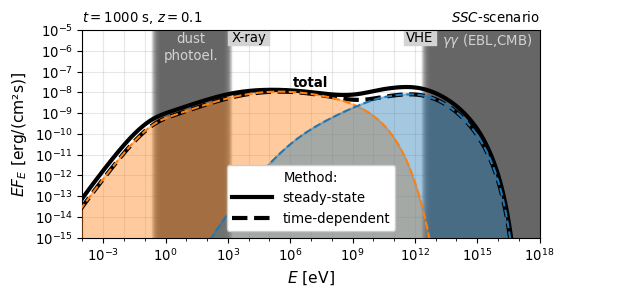

In [15]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", "steady-state", 3],
        [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_syn(), "tab:orange", True, 0, "--", None, 1.5],
        [Eg_erg*am3.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], cgrey="#666666", Emaxs_grey=[3e2, 1e18]
)

# ax.text(8e-3, 2e-10, r"primary $e$ syn.", color="tab:orange", va="center", ha="center", zorder=100, rotation=50)
# ax.text(2e15, 5e-10, r"primary $e$ IC.", color="tab:blue", va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-methods-blueorange")
fig

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/4155541560.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


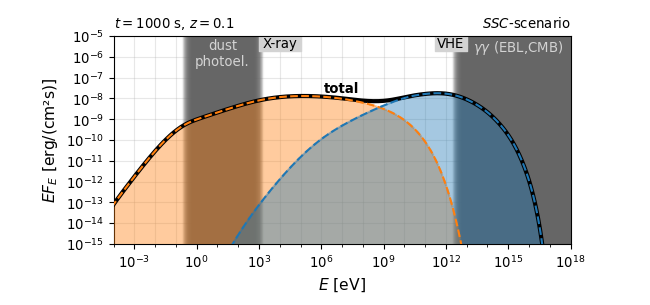

In [44]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", None, 3],
        # [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:orange", True, 0, "--", None, 1.5],
        [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], cgrey="#666666", Emaxs_grey=[3e2, 1e18]
)

# ax.text(8e-3, 2e-10, r"primary $e$ syn.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=50)
# ax.text(2e15, 5e-10, r"primary $e$ IC.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-steady-state_3")

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/4087179392.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


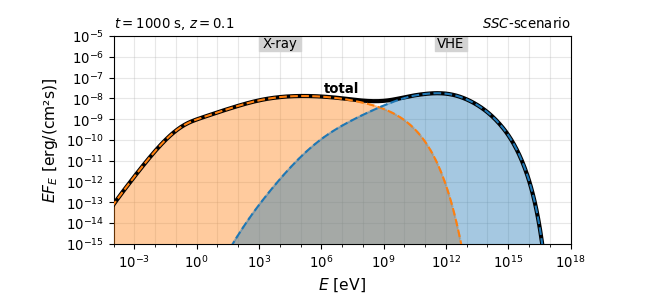

In [46]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", None, 3],
        # [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:orange", True, 0, "--", None, 1.5],
        [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-15, 1e-5], cgrey="None", Emaxs_grey=[3e2, 1e18], labels_grey=["",""]
)

# ax.text(8e-3, 2e-10, r"primary $e$ syn.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=50)
# ax.text(2e15, 5e-10, r"primary $e$ IC.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-8, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
# leg.set_zorder(100)
ax.set_title(r"$SSC$-scenario", loc="right")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-steady-state_2")

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_20878/1078339458.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


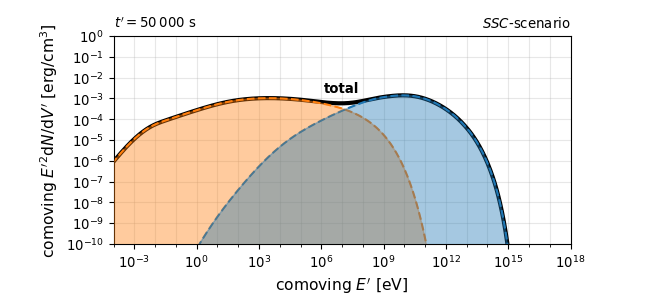

In [51]:
sfc.fullWidth(aspectRatio=0.47, alpha=0.8)
fig, (ax, axtbl) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [12, 1], "wspace":-.01})
ind = -1
ax.loglog(Eg_eV, Eg_erg*am3_ss.get_photons(), lw=3, c="k")
ax.loglog(Eg_eV, Eg_erg*am3_ss.get_photons_injected_electrons_syn(), lw=1.5, c="tab:orange", ls="--")
ax.fill_between(Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3_ss.get_photons_injected_electrons_syn(), color="tab:orange", zorder=10, alpha=0.4)
ax.loglog(Eg_eV, Eg_erg*am3_ss.get_photons_injected_electrons_compton(), lw=1.5, c="tab:blue", ls="--")
ax.fill_between(Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3_ss.get_photons_injected_electrons_compton(), color="tab:blue", zorder=10, alpha=0.4)

ax = plot_spectrum(
    ax, z, Gamma, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
    E2dN_dE_tot_gamma=Eg_erg*0, 
    E2dN_dE_tot_nu=En_erg*0,
    components=[
        # [Eg_erg*am3_wind.get_photons(), "k", False, 0, "-.", "wind", 3],
        # [Eg_erg*am3_ss.get_photons(), "k", False, 0, "-", None, 3],
        # [Eg_erg*am3.get_photons(), "k", False, 0, "--", "time-dependent", 3],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_syn(), "tab:blue", True, 0, "-.", "wind", 1.5],
        # [Eg_erg*am3_wind.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "-.", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:blue", False, 0, "-", "steady state", 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", False, 0, "-", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_ss.get_photons_injected_electrons_compton(), "tab:blue", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_syn(), "tab:orange", True, 0, "--", None, 1.5],
        # [Eg_erg*am3_const.get_photons_annihilation_pairs_compton(), "tab:orange", True, 0, "--", None, 1.5],
    ], ylim=[1e-10, 1e0], cgrey="None", Emaxs_grey=[3e2, 1e18], labels_grey=["",""], Emins_obs=[]
)
# ax.text(8e-3, 2e-10, r"primary $e$ syn.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=50)
# ax.text(2e15, 5e-10, r"primary $e$ IC.", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 3e-3, "total", color="k", va="center", ha="center", weight="bold")
# ax.text(2e14, 3e-12, r" $\gamma\gamma\to e^{\pm}$ IC.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=-50)
# ax.text(1e1, 1e-12, r" $\gamma\gamma\to e^{\pm}$ syn.", color=compcols["pair"], va="center", ha="center", zorder=100, rotation=35)

# leg = ax.legend(framealpha=1, loc="lower center", handlelength=3, title="Method:")
# leg.set_zorder(100)
ax.set_xlabel(r"comoving $E'$ [eV]")
ax.set_ylabel(r"comoving $E'^2 \mathrm{d}N/\mathrm{d}V'$ [erg/cm$^3$]")
ax.set_title(r"$SSC$-scenario", loc="right")
ax.set_title(r"$t'=50\,000$ s", loc="left")
axtbl.axis("off")

plt.subplots_adjust(right=0.99, bottom=0.2)
fig.tight_layout()
sfc.saveFigure(fig, f"SSC-spectrum-steady-state_1")

In [48]:
Gamma*1000

50118.72336272722